# Plant

I have a plant in my apartment. I have been secretly taking pictures of this plant for the last few months in order to run some analysis on what the plant has been doing while I have been away. Let's see this plant.

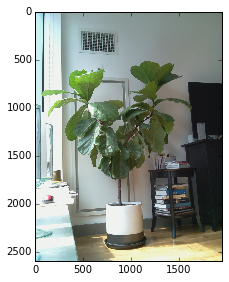

In [2]:
import os
import skimage.io as io
%matplotlib inline

images_dir = "072916"

# define all the plant files for the gif
file_names = sorted(("%s/%s" % (images_dir, fn) for fn in os.listdir("%s/." % images_dir) if fn.endswith('.jpg')))
num_images = len(file_names)

# pick plant in middle of the day
plant = io.imread(file_names[num_images//2])

io.imshow(plant)
io.show()

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(images,titles=None,f=plt.imshow,num_rows=None,num_cols=None):
    """ Display images side by side with their respective titles
        args: 
            images: list of image names
            titles (optional): list of image titles, defaults to 1..len(images)
            f (optional): type of plot, defaults to imshow
        returns:
            Nothing
    """
    num_ims = len(images)
    
    if num_rows is None and num_cols is None:
        # neither number of rows or number of columns provided
        # assume images should be displayed on one row
        num_rows = 1
        num_cols = num_ims
    elif num_rows is None:
        # columns provided, figure out how many rows to use
        num_rows = num_ims // num_cols
        if num_ims % num_cols != 0:
            num_rows += 1
    elif num_cols is None:
        # rows provided, figure out how many columns to use
        num_cols = num_ims // num_rows
        if num_ims % num_cols != 0:
            num_cols += 1
    if titles is None: 
        titles = ['(%d)' % i for i in range(1,num_ims + 1)]
        
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(num_rows,num_cols,n)
        if image.ndim == 2: 
            # Is image grayscale?
            plt.gray()
        f(image)
        a.set_title(title)
        n += 1

    fig.set_size_inches(np.array(fig.get_size_inches()) * (num_cols,num_rows))
    plt.show()
    

## Plant over time
Side by side, 30 minutes apart

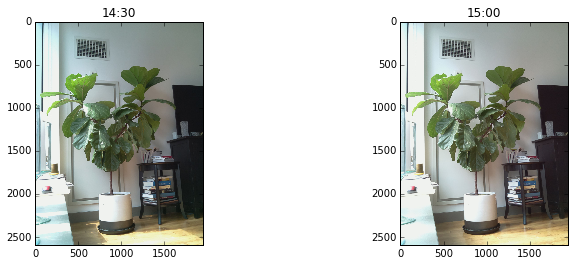

In [4]:
sample_image_names = file_names[num_images//2:num_images//2+2]
images = [io.imread(image) for image in sample_image_names]
show_images(images, [name[-9:-4] for name in sample_image_names])

Let's see this plant dance!

In [5]:
import imageio
from IPython.display import Image

images = [io.imread(fn) for fn in file_names]

filename = "plant_dance.gif"
imageio.mimsave('plant_dance.gif', images, duration=0.2)

Image(url='plant_dance.gif')

To be fair, plant is not in its youth anymore. Lets see plant from March 2016 and with a more flattering angle

In [6]:
Image(url='03-23-16.gif')

## Color Distribution

Let's look at the color distribution

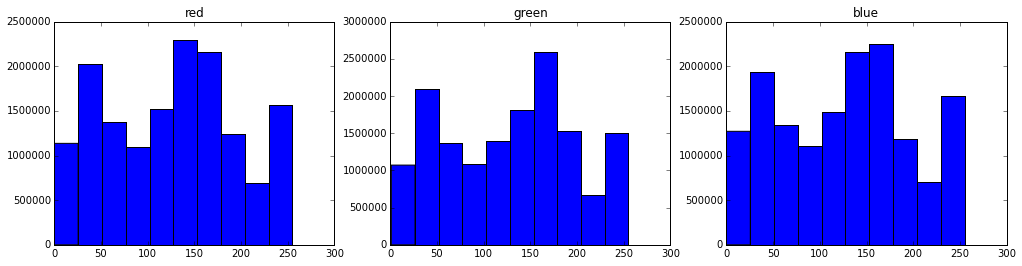

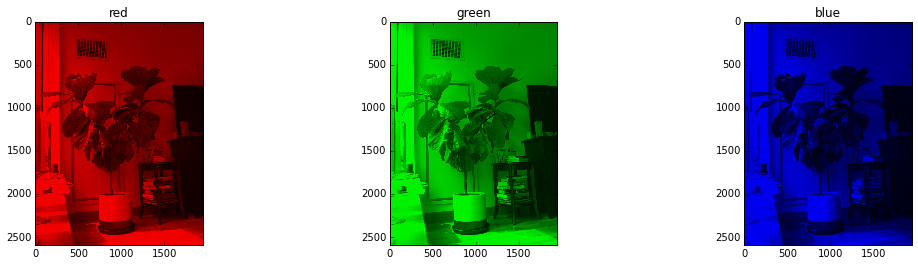

In [7]:
red, green, blue = plant[:,:,0], plant[:,:,1], plant[:,:,2]

images_hist = [image.flatten() for image in images]
titles = ['red','green','blue']

red_color, green_color, blue_color = plant.copy(), plant.copy(), plant.copy()

red_color[:,:,(1,2)] = 0
green_color[:,:,(0,2)] = 0
blue_color[:,:,(0,1)] = 0
images = [red_color, green_color, blue_color]

show_images(images_hist,titles=titles,f=plt.hist)
show_images(images,titles=titles)

Let's only look at the REALLY green stuff

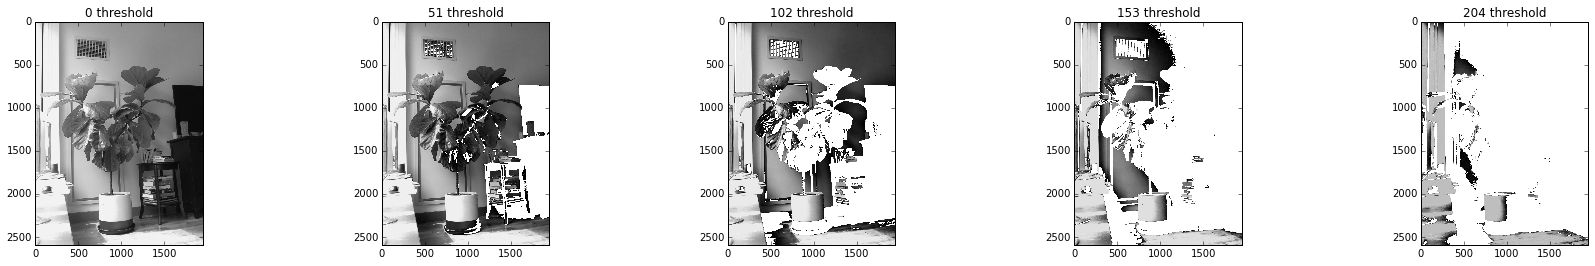

In [8]:
thresholds = range(0,255,255//5)
greens = []

for threshold in thresholds:
    temp_green = green.copy()
    temp_green[temp_green < threshold] = 255
    greens.append(temp_green)
show_images(greens,["%d threshold" % threshold for threshold in thresholds])

Okay, that didn't work. Maybe we can better identify the actual green color in grayscale. Grayscale removes a dimension from the image and uses floating points to represent the gray intensity. This way, we can identify a range between 0-1 to signify what we actually consider green.

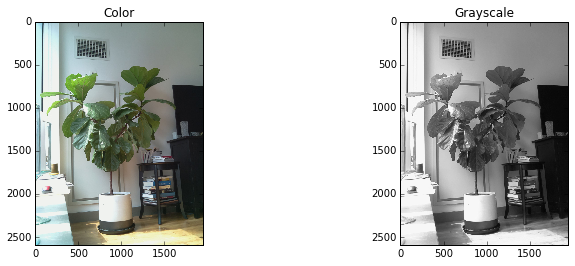

Color image shape (2592, 1944, 3)
Grayscale image shape (2592, 1944)


In [9]:
from skimage.color import rgb2gray

gray_plant = rgb2gray(plant)
show_images(images=[plant,gray_plant],titles=['Color','Grayscale'])

print "Color image shape %s" % str(plant.shape)
print "Grayscale image shape %s" % str(gray_plant.shape)


The distribution of the grayscale pixels may prove interesting. We can also equalize the gray distribution to improve contrast.


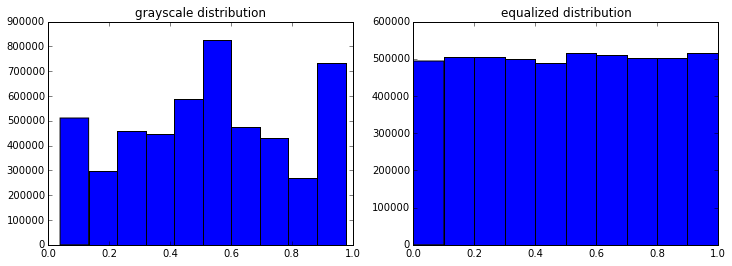

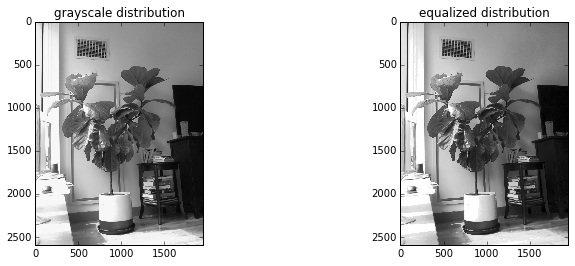

In [10]:
from skimage.exposure import equalize_hist

equalized_plant = equalize_hist(gray_plant)

hists = [gray_plant.flatten(), equalized_plant.flatten()]
titles = ['grayscale distribution', 'equalized distribution']

show_images(hists, titles=titles, f=plt.hist)
show_images([gray_plant,equalized_plant], titles=titles)

Perhaps if we try to remove some segments of gray.

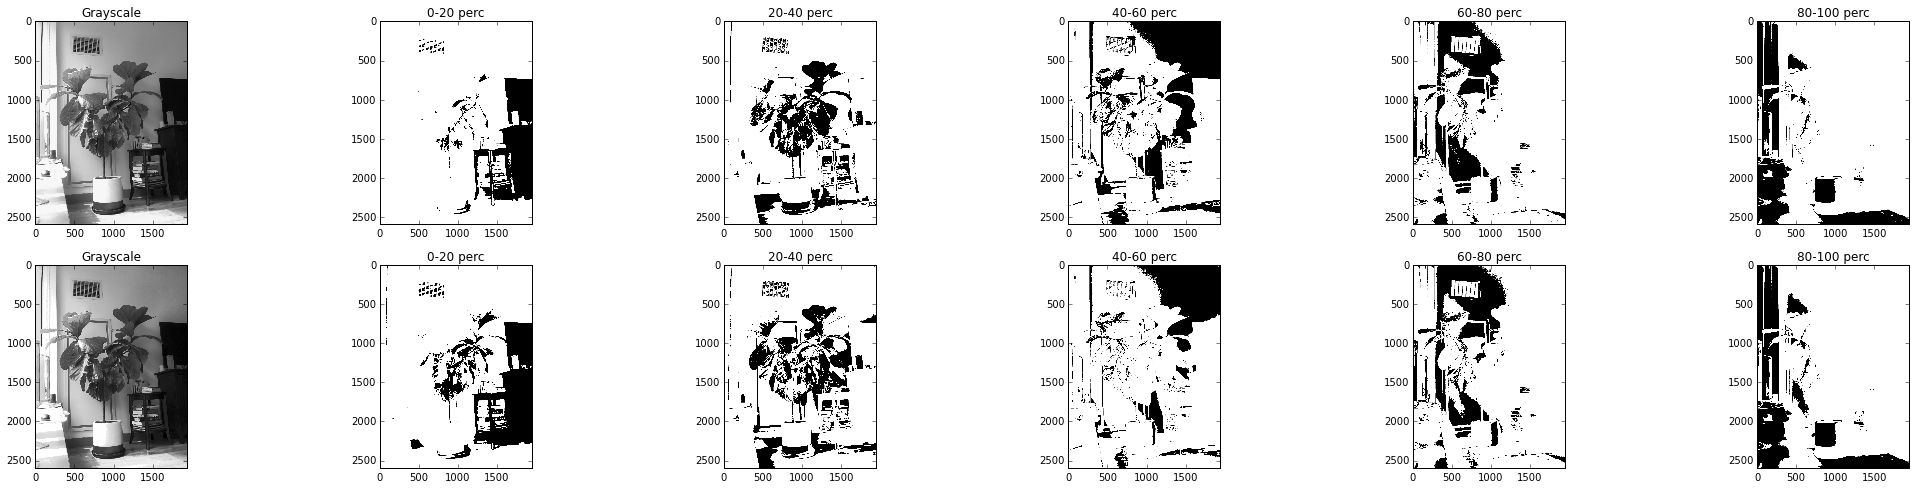

In [11]:
image_names = []
band_size = 20

def remove_image_segments(image, lo, hi):
    """
        Replaces the values of an nparray that are below lo and above hi with 1
        args: 
            image: np.array representing an image
            lo: float, low value, everything below this value will be 1.
            hi: float, hi value, everything above this value will be 1.
        returns:
            np.array where elements between lo and hi (inclusive) are black and
            everything else is white
    """
    image = im.copy()
    image[(im < lo) | (im > hi)] = 1. 
    image[(im >= lo) & (im <= hi)] = 0. 
    return image

images = []
for im in [gray_plant, equalized_plant]:    
    images.append(im)
    image_names.append("Grayscale")
    for i in range(100//band_size):
        lo = (i * band_size)/100.
        hi = ((i + 1) * band_size)/100.
        images.append(remove_image_segments(im,lo,hi))
        image_names.append("%d-%d perc" % (i * band_size, (i + 1) * band_size))
show_images(images=images, titles=image_names, num_rows=2)


Equalized image seems to work a little better. Let's crop out just the plant, and play with the grayscale bands to exclude.


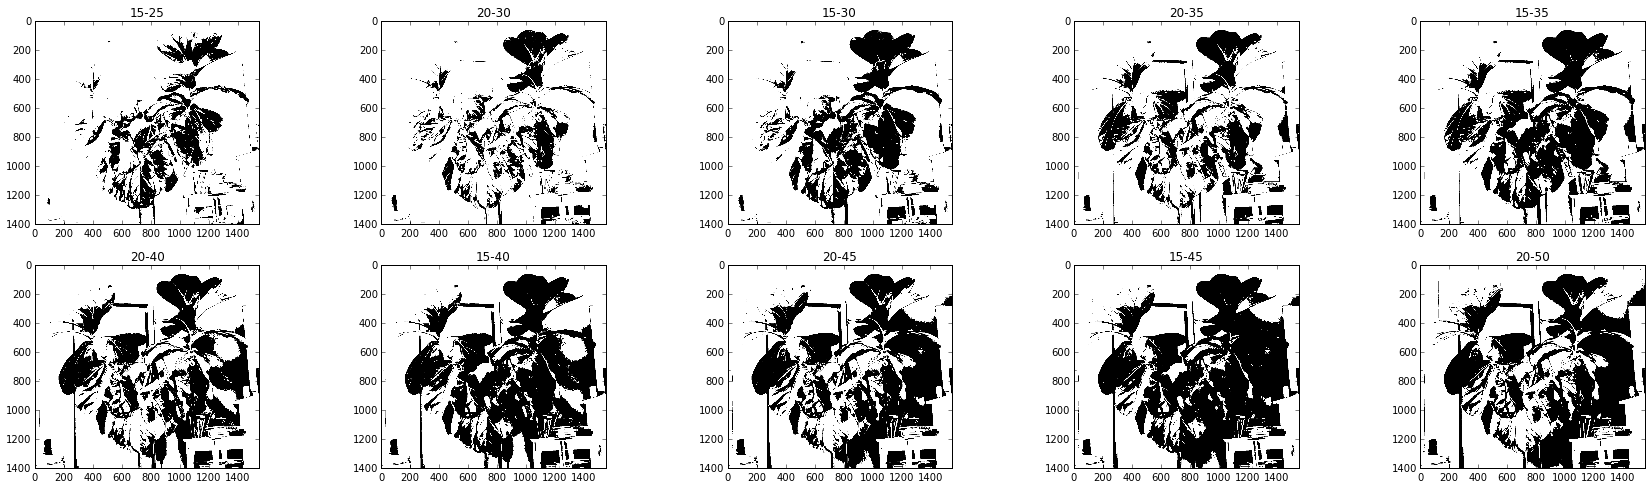

In [22]:
height_start = 450
height_end = 1850
width_start = 150
width_end = 1700

equalized_plant_cropped = equalized_plant[height_start:height_end,width_start:width_end]
im = equalized_plant_cropped
images = []
image_names = []
band_sizes = np.arange(0.1,0.35,0.05)
los = np.arange(0.15,0.25,0.05)

for band_size in band_sizes:
    for lo in los:
        hi = lo + band_size
        images.append(remove_image_segments(im, lo, hi))
        image_names.append("%d-%d" % (lo*100,hi*100))

show_images(images=images, titles=image_names, num_cols=len(band_sizes))

0.15 - 0.35 looks like a good band. Let's see what the image looks like in color


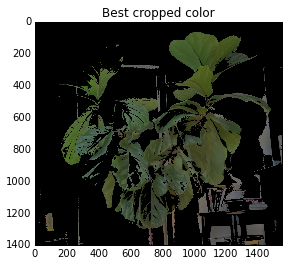

In [13]:
best_cropped = remove_image_segments(equalized_plant_cropped, 0.15, 0.35)

# add axis to equal (1400, 1550, 1) so we can multiply by (1400, 1550, 3)
best_cropped = np.expand_dims(best_cropped, axis=2) 

# flip 0s and 1 so everything not in cropped is made black
best_cropped = 1. - best_cropped 

plant_cropped = plant[height_start:height_end, width_start:width_end,]
best_cropped_color = plant_cropped.copy()
best_cropped_color *= best_cropped.astype(np.uint8)

show_images([best_cropped_color], ["Best cropped color"])

Eh... that didn't work too well Let's go back to the color display. What if we limit the [upper|lower] bounds of the [red|green|blue] values? Let's make this interactive.

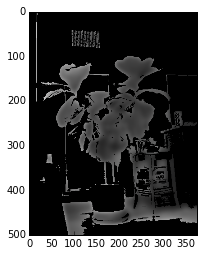

In [53]:
from ipywidgets import widgets

def change_color(lower_red=0,upper_red=255,
                 lower_green=0, upper_green=255,
                 lower_blue=0, upper_blue=255
                ):

    plant2 = gaussian_filter(plant_small, sigma=5)
    plant2[plant_small[:,:,0] > upper_red] = 0.
    plant2[plant_small[:,:,0] < lower_red] = 0.
    plant2[plant_small[:,:,1] > upper_green] = 0.
    plant2[plant_small[:,:,1] < lower_green] = 0.
    plant2[plant_small[:,:,2] > upper_blue] = 0.
    plant2[plant_small[:,:,2] < lower_blue] = 0.
    plt.imshow(plant2)


widgets.interact(change_color, 
                 lower_red=(0,255),
                 upper_red=(0,255),
                 lower_green=(0,255),
                 upper_green=(0,255),
                 lower_blue=(0,255),
                 upper_blue=(0,255)
                )


In [49]:
gaussian_filter(plant_small, sigma=3).shape

(500, 375, 3)

## Color Clustering

We're still not really identifying the green (plant) parts. Suppose we were to say that the image only consists of K colors and we force every pixel to be on of those K colors. From there we can include/exclude certain colors in hopes of trying to find the actual plant leaves.


In [41]:
import PIL

def shrink_image(img, width, height):
    """ Shrinks image to a thumbnail with specified width/height
        args:
            img: numpy array
            width: int
            height: int
        returns:
            numpy array with dim (width, height) in the appropriate scale
    """
    new_img = PIL.Image.fromarray(img)
    new_img.thumbnail((width,height), PIL.Image.ANTIALIAS)
    return np.array(new_img)

def unravel(ar):
    """ Unravels first two dimensions into one. E.g. (n, m, ...) -> (n * m, ...)
    args:
        ar: numpy array
    returns:
        numpy array with the first two dimensions unraveled
    """
    shape = list(ar.shape)
    return np.reshape(ar, [shape[0] * shape[1]] + shape[2:])

from sklearn.cluster import KMeans

def test_clusters(image, start_cluster, end_cluster):
    """ Dispays images with clustered-colors
    args:
        image: numpy array
        start_cluster: int
        end_cluster: int
    returns:
        None
    """
    image_unraveled = unravel(image)
    images = []
    labels = []
    for num_cluster in range(start_cluster,end_cluster + 1):
        kmeans = KMeans(n_clusters=num_cluster, random_state=0)
        kmeans.fit(image_unraveled)
        idxs = kmeans.predict(image_unraveled)
        image_new = np.array([kmeans.cluster_centers_[idx] for idx in idxs])
        image_new = np.reshape(image_new, original_shape)
    #     Uncommenting below would result in normal (boring) colors in the display below
    #     image_new = plant_new.astype(np.uint8)
        images.append(image_new)
        labels.append("%d clusters" % num_cluster)

    show_images(images, labels,num_cols=3)

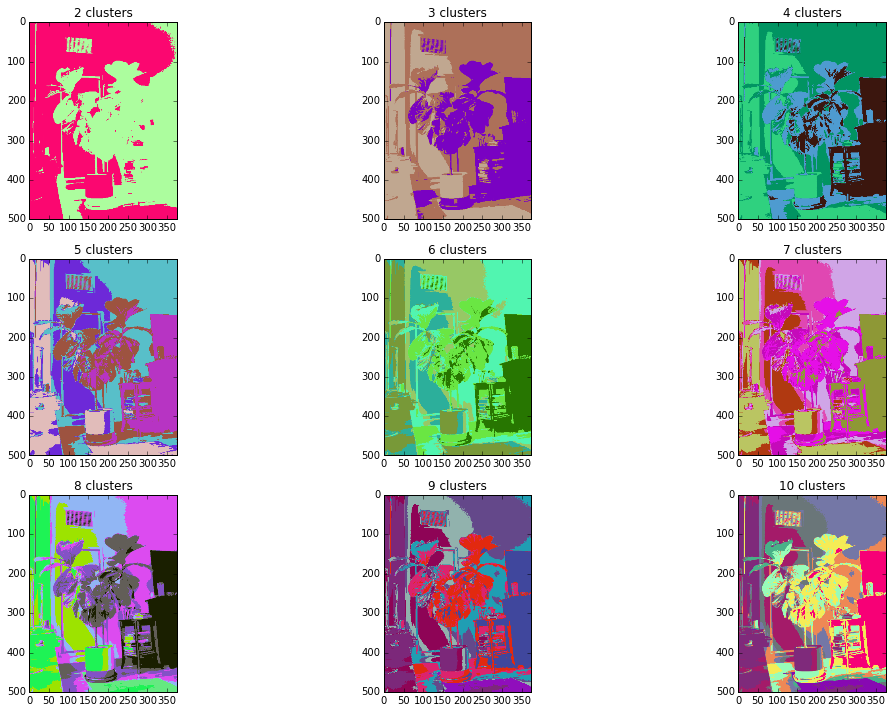

In [42]:
plant_small = shrink_image(plant,500,500)
test_clusters(plant_small, 2, 10)

There is still a lot of noise in our image. If we apply a blur, that may help.

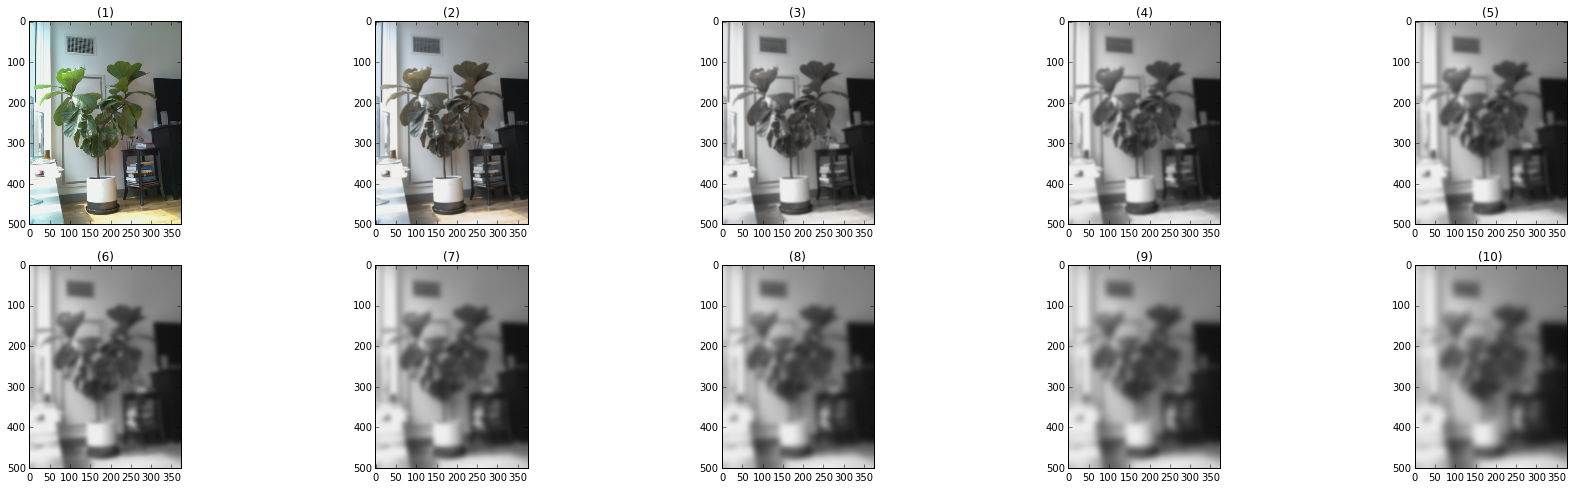

In [34]:
from scipy.ndimage import fourier_gaussian

show_images([gaussian_filter(plant_small, sigma=sigma) for sigma in range(10)], num_cols=5)

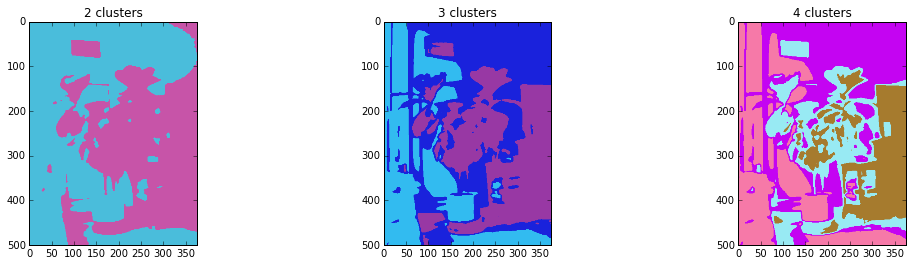

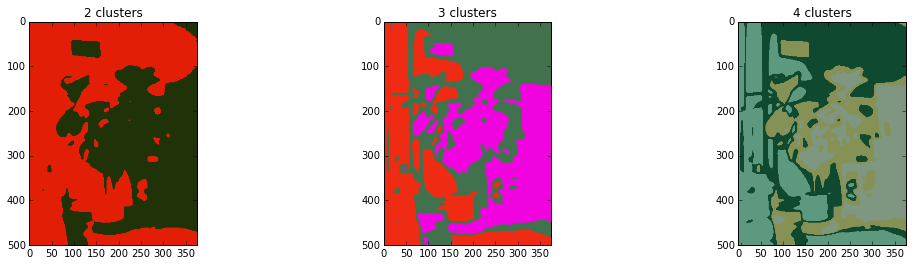

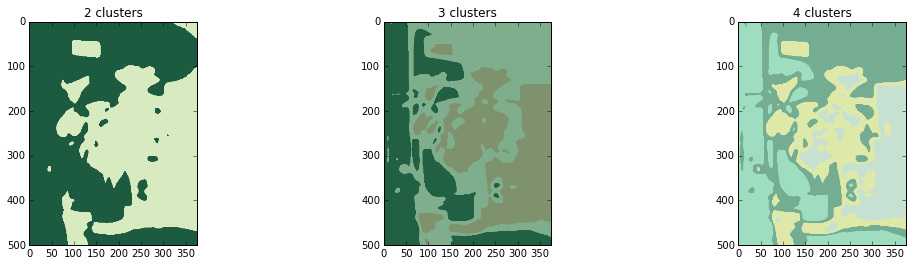

In [44]:
gaussian_plants = [gaussian_filter(plant_small, sigma=sigma) for sigma in range(2,5)]

for plant in gaussian_plants:
    test_clusters(plant,2,4)

### Fitting the color clustering model to images throughout the day

Let's see if these cluster groupings are applicable to other plants with different lighting
at different times of the day. Let's use 2 clusters and check out the plant every 6 hours.

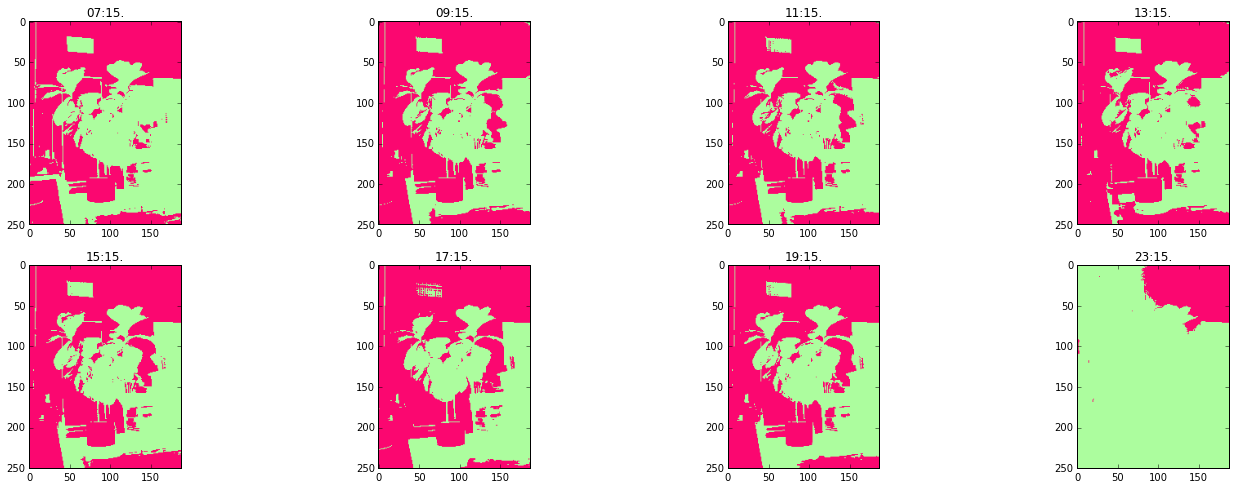

In [71]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(plant_small_unraveled)

clustered_images = []
clustered_images_names = file_names[::6]
clustered_images_titles = [name[-9:-3] for name in clustered_images_names]

all_plants = [shrink_image(io.imread(file_name),250,250) for file_name in clustered_images_names]

for plant in all_plants:
    idxs = kmeans.predict(unravel(plant).astype(np.float64))
    plant_new = np.array([kmeans.cluster_centers_[idx] for idx in idxs])
    plant_new = np.reshape(plant_new, plant.shape)
    clustered_images.append(plant_new)

show_images(clustered_images, num_cols=4, titles=clustered_images_titles)

It appears that the lighting in different parts of the day is throwing off our clustering alogirthm. We should probably use some kind of relative measure of pixel color by subtracting averages from each picture

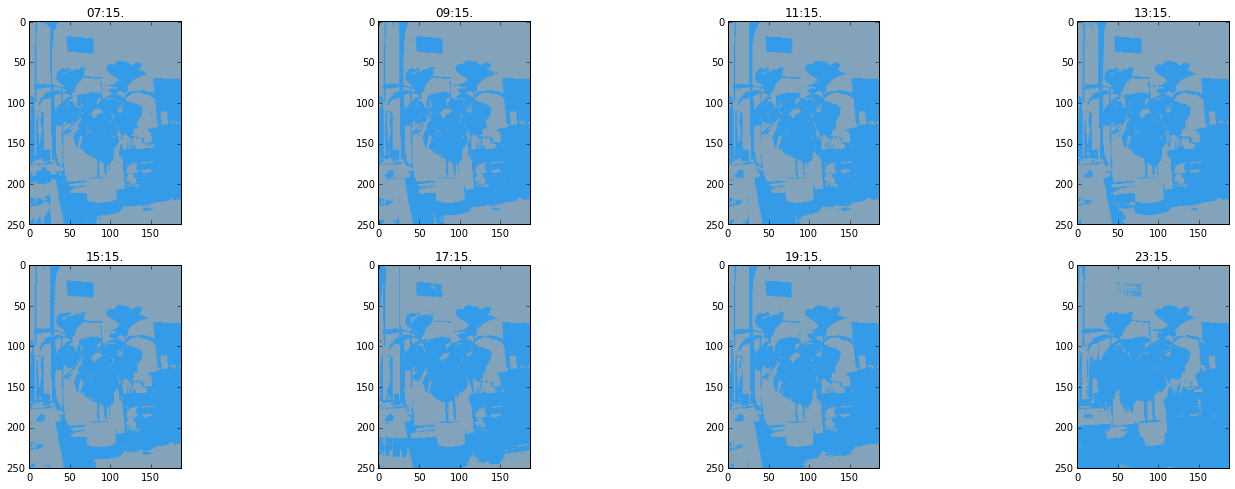

In [72]:
plant_small_unraveled_norm = plant_small_unraveled - plant_small_unraveled.mean(axis=0)

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(plant_small_unraveled_norm)

clustered_images = []

for plant in all_plants:
    plant_norm = plant - plant.mean(axis=0)
    idxs = kmeans.predict(unravel(plant_norm).astype(np.float64))
    plant_new = np.array([kmeans.cluster_centers_[idx] for idx in idxs])
    plant_new = np.reshape(plant_new, plant.shape)
    clustered_images.append(plant_new)

show_images(clustered_images, num_cols=4, titles=clustered_images_titles)